# Teste Data Science Elo7

### Descrição do Problema

Construir um classificador de produtos que recebe um conjunto de características de um produto e retorna a categoria dele.

### Dataset

Em resumo, o dataset contém 38.507 registros distribuídos em 5 categorias (Bebê, Bijuterias e Jóias, Decoração, Lembrancinhas, Papel e Cia e Outros). Cada registro corresponde a um clique em um produto a partir de um termo de busca no site.

Nesse dataset você encontrará as seguintes colunas:

 - product_id - identificação de produto
 - seller_id - identificação do vendedor
 - query - termo de busca inserido pelo usuário
 - search_page - número da página que o produto apareceu nos resultados de busca (mín 1 e máx 5)
 - position - número da posição que o produto apareceu dentro da página de busca (mín 0 e máx 38)
 - title - título do produto
 - concatenated_tags - tags do produto inseridas pelo vendedor (as tags estão concatenadas por espaço)
 - creation_date - data de criação do produto na plataforma do Elo7
 - price - preço do produto em reais
 - weight - peso em gramas da unidade do produto reportado pelo vendedor
 - express_delivery - indica se o produto é pronta entrega (1) ou não (0)
 - minimum_quantity - quantidade de unidades mínima necessária para compra
 - view_counts - número de cliques no produto nos últimos três meses
 - order_counts - número de vezes que o produto foi comprado nos últimos três meses
 - category - categoria do produto

# Importando as Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report

In [2]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

# Leitura dos Dados

In [3]:
dados = pd.read_csv('elo7_recruitment_dataset.csv')
dados.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [4]:
print('O conjunto de dados possui ',dados.shape[0],'linhas e ',dados.shape[1],'colunas.')

O conjunto de dados possui  38507 linhas e  15 colunas.


# Limpeza e Tratamento dos Dados

In [5]:
dados.dtypes

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts         float64
category              object
dtype: object

In [6]:
dados.isnull().sum()

product_id               0
seller_id                0
query                    0
search_page              0
position                 0
title                    0
concatenated_tags        2
creation_date            0
price                    0
weight                  58
express_delivery         0
minimum_quantity         0
view_counts              0
order_counts         20390
category                 0
dtype: int64

O maior numero de dados nulos estão na coluna 'order_counts'. Essa coluna informa número de vezes que o produto foi comprado nos últimos três meses. Esses dados podem ser nulos pois esses produtos não apresentaram nenhuma venda nos ultimos 3 meses, partindo disso, poderiamos substituir os valores de NaN por zero.

In [7]:
dados.loc[dados['order_counts'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração
5,4336889,3436479,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,49.970000,208.0,1,1,1093,NaN,Lembrancinhas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38498,2739553,7358636,polaina tricot,1,0,Polainas em Tricô,polainas,2013-07-15 16:58:47,55.870000,0.0,0,1,176,NaN,Bebê
38501,9920560,5631760,lembrancinhas para mulheres,1,0,Lembrancinha Chá de Mulheres,lembrancas lembrancinhas lembrancinha cha mulh...,2018-02-21 10:51:06,14.510000,10.0,0,14,535,NaN,Lembrancinhas
38504,972256,4840665,copo metalizado,1,3,Copos Metalizados - Rosé,despedida bianca metalizados xvdakaw lembranci...,2018-02-17 15:53:23,11.580000,25.0,1,104,306,NaN,Lembrancinhas
38505,7291315,6420917,festa do pijama menino,1,36,Kit Festa do Pijama Meninos,festa pijama,2016-08-21 22:33:59,131.330000,0.0,1,11,55,NaN,Lembrancinhas


In [8]:
dados.loc[dados['order_counts']==0.0]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category


In [9]:
dados['order_counts'] = dados['order_counts'].fillna(0)

In [10]:
dados.isnull().sum()

product_id            0
seller_id             0
query                 0
search_page           0
position              0
title                 0
concatenated_tags     2
creation_date         0
price                 0
weight               58
express_delivery      0
minimum_quantity      0
view_counts           0
order_counts          0
category              0
dtype: int64

Existem 58 dados nulos na coluna 'weight', provavelmente o vendedor não informou o peso do produto. Como são poucos dados em relação ao numero total de dados do conjunto, podemos excluir esses dados.

In [11]:
dados.loc[dados['weight'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
1764,15179518,2520540,sabonete,2,30,Sabonete líquido,sabonete sabonete liquido maternidade,2010-02-23 08:55:19,3.200000,NaN,0,15,104,0.0,Outros
2321,16688789,9060983,kit homenageados 15 anos,1,29,Kit homenageados pink e branco,15 anos,2012-10-28 21:16:10,24.310000,NaN,1,4,34,0.0,Lembrancinhas
2477,10145823,1417817,lembrancinha de casamento,4,15,lembrancinha de casamento,lembrancinhas,2012-08-07 21:05:36,14.030000,NaN,0,0,232,0.0,Lembrancinhas
4038,9797453,6000437,saco roupa suja,1,15,Saco para roupa suja,saco roupa suja,2011-09-01 05:44:28,35.340000,NaN,0,4,8,0.0,Outros
4115,10807030,139807,convite 90 anos,1,26,CONVITE DE 90 ANOS,convites personalizados 10x15,2012-09-23 09:43:45,12.060000,NaN,1,15,48,0.0,Papel e Cia
5257,12242119,431519,cartao de agradecimento cha de fraldas,1,3,TAG/MINI CARTÃO - CHÁ DE FRALDAS,bebes tags cartoes,2010-07-27 16:59:18,9.870000,NaN,1,34,104,0.0,Papel e Cia
5892,3301068,3058025,lembrancinha de maternidade diferente,1,12,"Lembrancinhas, aniversário, maternidade",lembrancinhas maternidade tata bloquinhos lemb...,2012-07-28 12:31:23,15.000000,NaN,1,24,962,0.0,Bebê
6532,12775302,10020204,cartao dia dos pais,1,2,Cartão Dia dos Pais,cartoes,2012-08-10 14:56:30,12.190000,NaN,1,0,228,0.0,Papel e Cia
7034,13613187,546025,tapete para banheiro de barbante,1,19,Tapetes de Barbantes,tapetes barbante decoracao tapete barbante,2012-05-28 10:12:27,243.340000,NaN,1,0,95,0.0,Decoração
7307,11038478,7879862,lembranca,1,37,LEMBRANÇA DE CASAMENTO,009 casamento lembranca casamento casamento,2011-03-29 17:01:00,12.950000,NaN,1,22,227,0.0,Outros


O mesmo raciocínio adotado para tratar os valores nulos da coluna 'weight' pode ser adotada para a coluna 'concatenated_tags', que tem apenas 2 valores nulos.

In [12]:
dados.loc[dados['concatenated_tags'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
6359,9247896,8344716,stranger things,2,30,Caixinha Stranger Things,NaN,2018-06-01 23:13:18,62.9,329.0,1,5,121,10.0,Decoração
29809,8132534,6790389,prateleira para gatos,1,5,Kit Ponte Passarela para Gatos com 2 prateleiras,NaN,2018-03-28 15:29:07,107.8,3808.0,0,1,202,7.0,Outros


In [13]:
dados.dropna(inplace=True)

In [14]:
dados.isnull().sum()

product_id           0
seller_id            0
query                0
search_page          0
position             0
title                0
concatenated_tags    0
creation_date        0
price                0
weight               0
express_delivery     0
minimum_quantity     0
view_counts          0
order_counts         0
category             0
dtype: int64

In [15]:
print('O conjunto de dados possui ',dados.shape[0],'linhas e ',dados.shape[1],'colunas após excluirmos os valores nulos.')

O conjunto de dados possui  38447 linhas e  15 colunas após excluirmos os valores nulos.


In [16]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38447 entries, 0 to 38506
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         38447 non-null  int64  
 1   seller_id          38447 non-null  int64  
 2   query              38447 non-null  object 
 3   search_page        38447 non-null  int64  
 4   position           38447 non-null  int64  
 5   title              38447 non-null  object 
 6   concatenated_tags  38447 non-null  object 
 7   creation_date      38447 non-null  object 
 8   price              38447 non-null  float64
 9   weight             38447 non-null  float64
 10  express_delivery   38447 non-null  int64  
 11  minimum_quantity   38447 non-null  int64  
 12  view_counts        38447 non-null  int64  
 13  order_counts       38447 non-null  float64
 14  category           38447 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 4.7+ MB


# Análise Exploratória

Essa parte consiste na exploração dos dados, com o objetivo de conhecer os dados e tirar algumas informações que podem ser importantes para o sistema de classificação.

### Estatísticas Descritivas

In [17]:
dados.describe()

,product_id,seller_id,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts
count,3.844700e+04,3.844700e+04,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000
mean,8.341086e+06,5.009940e+06,1.491690,16.892918,84.122273,361.747965,0.780555,14.603766,545.986397,12.901709
std,4.835196e+06,2.947308e+06,0.980153,11.589345,211.952413,1820.777260,0.413876,43.800200,1417.489218,43.743231
min,3.610000e+02,8.170000e+02,1.000000,0.000000,0.070000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4.137908e+06,2.473568e+06,1.000000,6.000000,12.760000,6.000000,1.000000,3.000000,119.000000,0.000000
50%,8.371889e+06,4.917720e+06,1.000000,16.000000,28.529999,9.000000,1.000000,7.000000,243.000000,0.000000
75%,1.252850e+07,7.638876e+06,2.000000,27.000000,90.000000,107.000000,1.000000,16.000000,521.000000,14.000000
max,1.669295e+07,1.011887e+07,5.000000,38.000000,11509.380000,65009.000000,1.000000,3000.000000,45010.000000,2460.000000


A função describe mostra algumas informações estatísticas sobre as variáveis numericas. Temos a contagem de variáveis, o valor da média de cada variável, o desvio padrão, o valor mínimo e máximo, o percentil inferior e superior (25% e 75%) e o percentil de 50% que é o mesmo que a mediana.

Podemos ver que a coluna do peso ('weight') possui valor mínimo igual a zero. Esses valores possivelmente estão errados, será necessário exclui-los do conjunto de dados. Antes de excluir, vamos ver quantos valores são iguais a zero.

In [18]:
dados.loc[dados['weight']==0.0]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
14,5257665,8519033,chinelo personalizado casamento,3,9,Chinelo personalizado casamento azul,porta guardanapos casamento lembrancas casorio,2017-12-28 00:55:28,5.890000,0.0,1,53,311,0.0,Lembrancinhas
18,9082256,4680202,sacola personalizada dia dos pais,2,15,Caneca Dia dos Pais Personalizada - Feliz Dia ...,canecas personalizadas,2018-07-14 09:14:56,24.900000,0.0,1,1,78,1.0,Lembrancinhas
25,7340505,4131779,lembrancinha de 15 anos,1,18,LEMBRANCINHA 15 ANOS,15 anos casamento,2011-11-05 00:20:58,18.170000,0.0,1,10,343,0.0,Lembrancinhas
30,7621260,7274093,saia para berco americano,1,29,Saia para Berço Americano,enxoval acessorios,2015-07-03 22:04:37,84.700000,0.0,1,9,82,25.0,Bebê
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38476,14166766,4548056,lembrancinhas dia do professor,1,2,Lembrancinha Dia dos Professores,lembrancinha dia professores,2016-03-26 10:27:14,22.780000,0.0,1,10,268,0.0,Lembrancinhas
38478,5385130,8444884,tubolata,1,36,Lembrança Tubolata Ferrari,kit personalizados ferrari tubolata,2017-05-02 23:06:18,15.760000,0.0,1,15,65,0.0,Lembrancinhas
38488,11489843,1820260,caneca personalizada dia dos pais,2,31,Caneca Inox Personalizada 180ml C/ Tampa,brindes casamento dia pais lembrancinhas casorio,2017-02-01 13:51:55,20.910000,0.0,1,20,352,0.0,Lembrancinhas
38498,2739553,7358636,polaina tricot,1,0,Polainas em Tricô,polainas,2013-07-15 16:58:47,55.870000,0.0,0,1,176,0.0,Bebê


Temos 4398 registros com valor de peso igual a zero. Isso representa 11,43% do total de registros. Se olharmos quais produtos estão com peso igual a zero, vemos muitos produtos diferentes, e alguns são bem genericos, por exemplo o produto "Lembrancinha Dia dos Professores". Não dá pra saber que tipo de lembrancinha é, as vezes o vendedor produz varios tipos de lembrancinhas e dependendo do tipo escolhido pelo cliente o peso vai ser diferente. O que explicaria a variável peso não ter nenhum peso especificado. 

O problema de deixar essa variável igual a zero, é que sua distribuição será afetada por isso, o que pode também influenciar o sistema de classificação. Temos duas opções aqui, ou excluimos esses dados, ou substituimos por outro valor. Vamos olhar as estatísticas descritivas da variável peso quando os dados são agrupados por categoria.

In [19]:
dados.groupby('category')['weight'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,7015.0,394.424804,1425.323738,0.0,6.0,9.0,209.0,55007.0
Bijuterias e Jóias,951.0,61.232387,366.584620,0.0,6.0,9.0,19.0,8006.0
Decoração,8836.0,989.146446,3091.792320,0.0,7.0,156.0,712.0,65009.0
Lembrancinhas,17746.0,63.299560,277.027696,0.0,6.0,9.0,29.0,11006.0
Outros,1137.0,765.503078,4296.793777,0.0,7.0,10.0,175.0,60009.0
Papel e Cia,2762.0,126.434830,538.097324,0.0,6.0,8.0,30.0,15007.0


Os valores de peso por categoria possuem um desvio padrão bem alto, variando bastante. Talvez a decisão mais segura seja excluir os dados em que a variável peso é igual a zero.

In [20]:
excluir = dados.loc[dados['weight']==0.0]

In [21]:
dados.drop(excluir.index,axis=0,inplace=True)

In [22]:
print('O conjunto de dados possui ',dados.shape[0],'linhas e ',dados.shape[1],'colunas após excluirmos os valores iguais a zero da variável peso.')

O conjunto de dados possui  34049 linhas e  15 colunas após excluirmos os valores iguais a zero da variável peso.


Quantos valores unicos existem em cada coluna do conjunto de dados?

In [23]:
dados.nunique()

product_id           26935
seller_id             8101
query                 6199
search_page              5
position                39
title                23079
concatenated_tags    21020
creation_date        26931
price                13985
weight                1194
express_delivery         2
minimum_quantity       157
view_counts           2981
order_counts           344
category                 6
dtype: int64

Existem 26.935 produtos nesse conjunto de dados, 8.101 vendedores e 6.199 termos de busca diferentes utilizados.

Se temos 34.049 linhas no conjunto de dados, e 26.935 produtos, então existem produtos que aparecem mais de uma vez. Lembrando que, cada linha do conjunto de dados corresponde a um clique em um produto a partir de um termo de busca no site.

Quais os produtos aparecem mais de uma vez no conjunto de dados?

In [24]:
dados['product_id'].value_counts().sort_values(ascending=False)

7557702     14
11130723    12
2952037     11
9715550     11
9059093     10
            ..
9151626      1
9542797      1
14111892     1
13879166     1
14243630     1
Name: product_id, Length: 26935, dtype: int64

In [25]:
dados.loc[dados['product_id']==7557702]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
1286,7557702,8888785,lembrancinha para o dia dos pais,1,14,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,10.30,57.0,1,15,3175,39.0,Lembrancinhas
1688,7557702,8888785,lembrancinha personalizada dia dos pais,1,0,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,20.18,57.0,1,16,3201,37.0,Lembrancinhas
2438,7557702,8888785,pais,3,16,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,18.45,50.0,1,15,3167,39.0,Lembrancinhas
6270,7557702,8888785,presente dia dos pais,2,14,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,20.27,50.0,1,13,3186,39.0,Lembrancinhas
8859,7557702,8888785,lembrancinha dia dos pais,2,1,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,20.47,60.0,1,10,3192,43.0,Lembrancinhas
23449,7557702,8888785,dia dos pais,1,13,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,18.33,56.0,1,10,3175,54.0,Lembrancinhas
24019,7557702,8888785,lembrancinha kit barbear dia dos pais,1,1,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,19.81,56.0,0,10,3185,32.0,Lembrancinhas
25582,7557702,8888785,presente personalizado dia dos pais,4,13,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,20.56,55.0,1,19,3150,32.0,Lembrancinhas
26312,7557702,8888785,kit barbear dia dos pais,1,1,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,10.30,57.0,1,10,3184,42.0,Lembrancinhas
28216,7557702,8888785,lembrancinhas corporativas dia dos pais,1,24,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,18.86,58.0,1,15,3186,32.0,Lembrancinhas


In [26]:
aux = pd.DataFrame({'qtd_duplicado':dados['product_id'].value_counts().sort_values(ascending=False)})
aux.query('qtd_duplicado >1').count()

qtd_duplicado    5020
dtype: int64

Existem 5020 produtos que aparecem mais de uma vez no conjunto de dados.

Quantos produtos possuem pronta entrega e quantos não? Qual a porcentagem que isso representa?

In [27]:
dados['express_delivery'].value_counts()

1    26423
0     7626
Name: express_delivery, dtype: int64

In [28]:
dados['express_delivery'].value_counts()/dados.shape[0]

1    0.776029
0    0.223971
Name: express_delivery, dtype: float64

A maioria dos produtos (77,6%) estão disponíveis a pronta entrega.

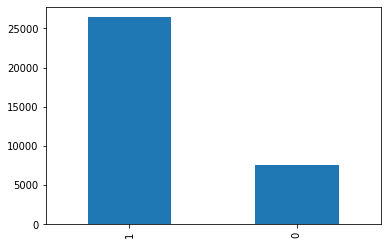

In [29]:
dados['express_delivery'].value_counts().plot(kind='bar')

Quantos registros há em cada categoria? Qual a porcentagem que isso representa?

In [30]:
dados['category'].value_counts()

Lembrancinhas         15533
Decoração              8070
Bebê                   6153
Papel e Cia            2419
Outros                 1036
Bijuterias e Jóias      838
Name: category, dtype: int64

In [31]:
dados['category'].value_counts()/dados.shape[0]

Lembrancinhas         0.456195
Decoração             0.237011
Bebê                  0.180710
Papel e Cia           0.071045
Outros                0.030427
Bijuterias e Jóias    0.024612
Name: category, dtype: float64

O conjunto de dados é composto por 6 categorias, sendo a maior parte dos registros, 45,61%, pertence a categoria de Lembrancinhas, 23,7% pertence a categoria de Decoração e 18,07% a categoria de Bebê. Essas 3 categorias representam a maior parte do conjunto de dados. As outras 3 categorias representam a menor porcentagem dos dados, a categoria Papel e Cia possui 7,1% dos dados, Bijuteria e Jóias 3% e 2,46% estão na categoria Outros.

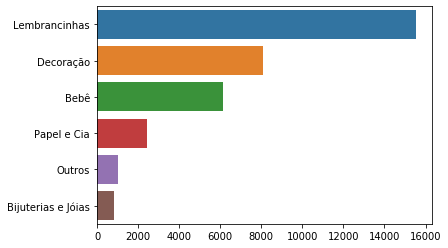

In [32]:
sns.barplot(dados['category'].value_counts().values,dados['category'].value_counts().index)

Quantos vendedores existem em cada categoria?

In [33]:
dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False)

category
Lembrancinhas         3037
Decoração             2628
Bebê                  1890
Papel e Cia            887
Outros                 488
Bijuterias e Jóias     340
Name: seller_id, dtype: int64

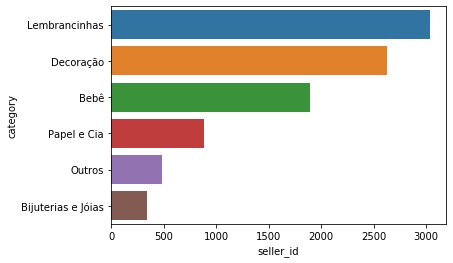

In [34]:
sns.barplot(dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False),
            dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False).index)

Quantos produtos existem em cada categoria?

In [35]:
dados.groupby('category')['product_id'].nunique().sort_values(ascending=False)

category
Lembrancinhas         11509
Decoração              6836
Bebê                   4857
Papel e Cia            2034
Outros                  930
Bijuterias e Jóias      769
Name: product_id, dtype: int64

Como é a distribuição da variável preço?

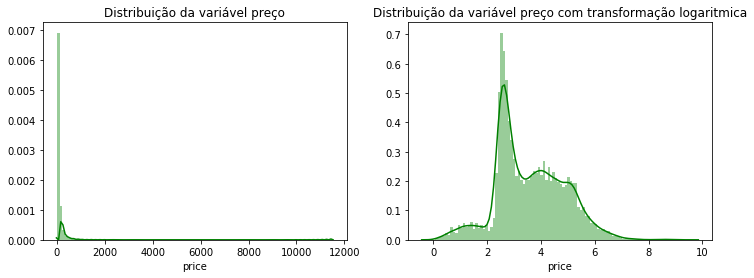

In [36]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['price'], color='g', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.log1p(dados['price']), color='g', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável preço')
axs[1].set_title('Distribuição da variável preço com transformação logaritmica')
plt.show()

#### BoxPlot

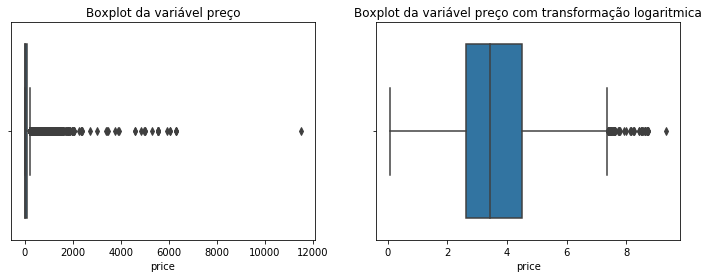

In [37]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(dados['price'],ax=axs[0])
sns.boxplot(np.log1p(dados['price']),ax=axs[1])
axs[0].set_title('Boxplot da variável preço')
axs[1].set_title('Boxplot da variável preço com transformação logaritmica')
plt.show()

In [38]:
dados['price'].describe()

count    34049.000000
mean        84.314645
std        210.955558
min          0.070000
25%         12.810000
50%         29.380000
75%         90.770000
max      11509.380000
Name: price, dtype: float64

In [39]:
dados.query('price == 11509.38')

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
15533,6003202,1308482,bebe reborn silicone solido,1,5,Boneca bebê de silicone sólido ecoflex Coral,rutimara aparecida pereira,2018-11-21 23:38:58,11509.38,8.0,0,5,1597,0.0,Bebê


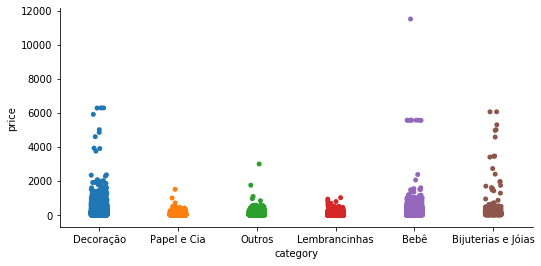

In [40]:
ax = sns.catplot(x='category', y='price',data=dados, aspect=2, height=3.8)

In [41]:
dados.groupby('category')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,6153.0,146.443598,286.266176,0.35,42.330000,99.920,179.3600,11509.3800
Bijuterias e Jóias,838.0,194.886431,531.948801,2.99,40.992500,89.555,169.9625,6060.1997
Decoração,8070.0,154.522201,268.320659,0.45,46.105002,80.620,168.0050,6289.4200
Lembrancinhas,15533.0,24.387080,42.282560,0.12,10.840000,13.550,19.9800,1017.6000
Outros,1036.0,65.477432,143.272231,0.15,15.585000,30.385,62.3225,2998.7100
Papel e Cia,2419.0,46.636528,67.177981,0.07,11.130000,25.690,60.1550,1508.9400


Como é a distribuição da variável peso?

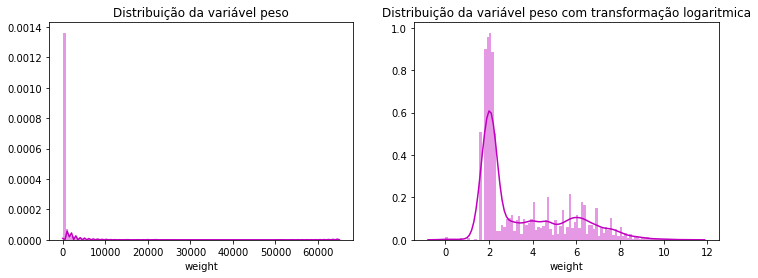

In [42]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['weight'], color='m', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.log(dados['weight']), color='m', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável peso')
axs[1].set_title('Distribuição da variável peso com transformação logaritmica')
plt.show()

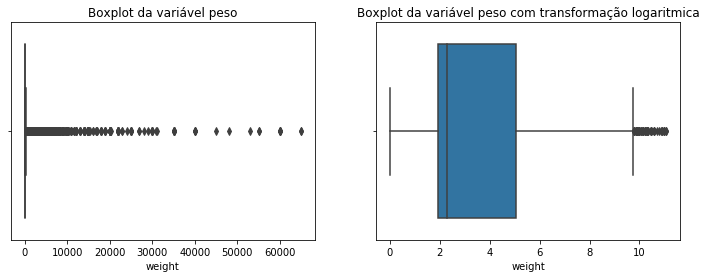

In [43]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(dados['weight'],ax=axs[0])
sns.boxplot(np.log(dados['weight']),ax=axs[1])
axs[0].set_title('Boxplot da variável peso')
axs[1].set_title('Boxplot da variável peso com transformação logaritmica')
plt.show()

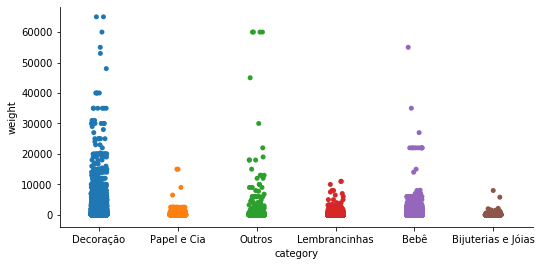

In [44]:
ax = sns.catplot(x='category', y='weight',data=dados, aspect=2, height=3.8)

In [45]:
dados.groupby('category')['weight'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,6153.0,449.681456,1513.720673,1.0,7.0,10.0,307.00,55007.0
Bijuterias e Jóias,838.0,69.489260,389.810871,1.0,7.0,10.0,21.00,8006.0
Decoração,8070.0,1083.035688,3219.463671,1.0,8.0,210.5,808.75,65009.0
Lembrancinhas,15533.0,72.317904,295.002800,1.0,7.0,9.0,39.00,11006.0
Outros,1036.0,840.132239,4494.588551,1.0,8.0,18.0,208.00,60009.0
Papel e Cia,2419.0,144.362547,572.741528,1.0,7.0,9.0,60.00,15007.0


Quais produtos tiveram os maiores números de cliques nos ultimos 3 meses? A qual categoria esses produtos pertencem?

In [46]:
dados.groupby('category')['view_counts'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,6153.0,734.769381,2239.309129,1.0,142.00,300.0,644.00,41544.0
Bijuterias e Jóias,838.0,531.980907,1300.376850,1.0,82.25,185.0,394.75,18246.0
Decoração,8070.0,434.818340,1212.381671,1.0,102.00,200.0,418.00,45010.0
Lembrancinhas,15533.0,564.600270,1229.851785,1.0,128.00,265.0,570.00,31372.0
Outros,1036.0,497.423745,979.101630,2.0,101.00,196.5,431.25,8408.0
Papel e Cia,2419.0,439.622571,953.886960,3.0,99.00,193.0,437.00,17332.0


Como é a distribuição da variável quantidade mínima?

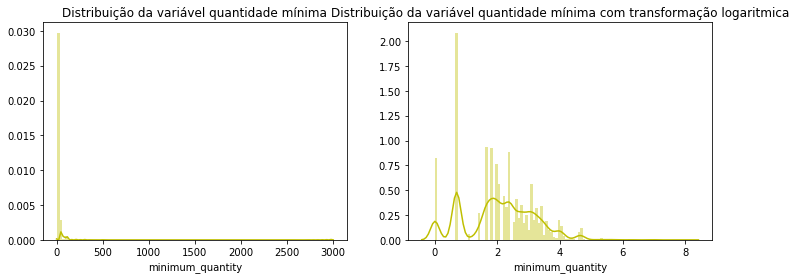

In [47]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['minimum_quantity'], color='y', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.log1p(dados['minimum_quantity']), color='y', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável quantidade mínima')
axs[1].set_title('Distribuição da variável quantidade mínima com transformação logaritmica')
plt.show()

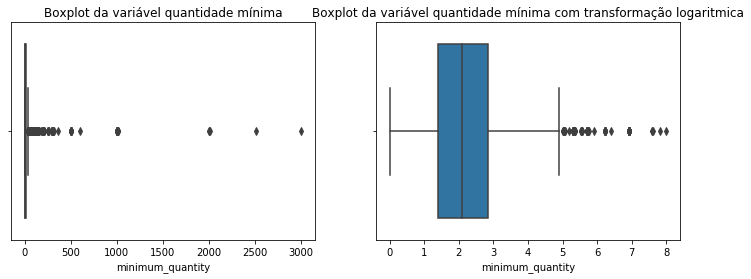

In [48]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(dados['minimum_quantity'],ax=axs[0])
sns.boxplot(np.log1p(dados['minimum_quantity']),ax=axs[1])
axs[0].set_title('Boxplot da variável quantidade mínima')
axs[1].set_title('Boxplot da variável quantidade mínima com transformação logaritmica')
plt.show()

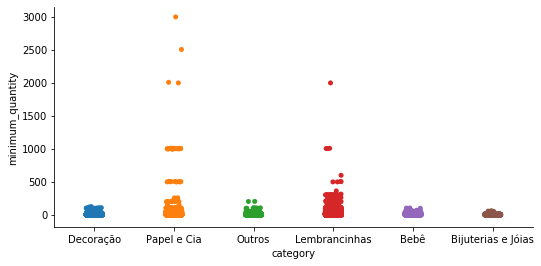

In [49]:
ax = sns.catplot(x='category', y='minimum_quantity',data=dados, aspect=2, height=3.8)

In [50]:
dados.groupby('category')['minimum_quantity'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,6153.0,6.319356,7.894825,0.0,1.0,5.0,8.0,104.0
Bijuterias e Jóias,838.0,4.373508,5.169769,0.0,1.0,4.0,7.0,61.0
Decoração,8070.0,4.671128,5.911471,0.0,1.0,4.0,7.0,125.0
Lembrancinhas,15533.0,21.629563,33.922575,0.0,8.0,15.0,25.0,2000.0
Outros,1036.0,7.361004,15.273196,0.0,1.0,4.0,8.0,204.0
Papel e Cia,2419.0,30.125672,139.632298,0.0,1.0,7.0,19.0,3000.0


Como é a distribuição da variável 'order_counts' (número de vezes que o produto foi comprado nos últimos três meses)?

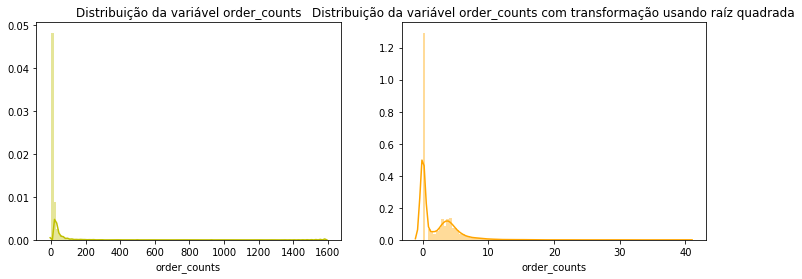

In [51]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['order_counts'], color='y', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.sqrt(dados['order_counts']), color='orange', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável order_counts')
axs[1].set_title('Distribuição da variável order_counts com transformação usando raíz quadrada')
plt.show()

In [52]:
dados.corr()

,product_id,seller_id,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts
product_id,1.000000,-0.010979,0.000484,-0.000423,0.005685,0.001216,-0.009249,-0.006523,0.009633,0.004273
seller_id,-0.010979,1.000000,-0.014522,-0.013768,0.005652,0.012211,-0.003246,0.013139,0.013133,0.003762
search_page,0.000484,-0.014522,1.000000,0.053006,-0.002287,-0.022631,0.029201,0.022142,-0.021571,-0.000711
position,-0.000423,-0.013768,0.053006,1.000000,-0.001709,-0.011441,0.002593,0.008103,-0.064933,-0.043330
price,0.005685,0.005652,-0.002287,-0.001709,1.000000,0.229079,-0.042714,-0.078923,-0.003366,-0.018182
weight,0.001216,0.012211,-0.022631,-0.011441,0.229079,1.000000,-0.051836,-0.038941,0.012485,0.004995
express_delivery,-0.009249,-0.003246,0.029201,0.002593,-0.042714,-0.051836,1.000000,0.085541,-0.017063,-0.049548
minimum_quantity,-0.006523,0.013139,0.022142,0.008103,-0.078923,-0.038941,0.085541,1.000000,0.032400,0.005548
view_counts,0.009633,0.013133,-0.021571,-0.064933,-0.003366,0.012485,-0.017063,0.032400,1.000000,0.606538
order_counts,0.004273,0.003762,-0.000711,-0.043330,-0.018182,0.004995,-0.049548,0.005548,0.606538,1.000000


In [53]:
dados.corr(method='spearman')

,product_id,seller_id,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts
product_id,1.000000,-0.010871,-0.000930,-0.000430,-0.004378,0.006698,-0.009263,0.002838,-0.003507,-0.005137
seller_id,-0.010871,1.000000,-0.017486,-0.013503,0.017495,0.022927,-0.003027,-0.004030,0.006645,0.000502
search_page,-0.000930,-0.017486,1.000000,0.059349,-0.061371,-0.024852,0.033304,0.081406,-0.031664,0.012663
position,-0.000430,-0.013503,0.059349,1.000000,-0.011387,-0.012420,0.002852,0.020912,-0.139870,-0.041739
price,-0.004378,0.017495,-0.061371,-0.011387,1.000000,0.264611,-0.169019,-0.639974,-0.039017,0.091435
weight,0.006698,0.022927,-0.024852,-0.012420,0.264611,1.000000,-0.119293,-0.213319,-0.008859,0.194659
express_delivery,-0.009263,-0.003027,0.033304,0.002852,-0.169019,-0.119293,1.000000,0.285307,0.038338,-0.089412
minimum_quantity,0.002838,-0.004030,0.081406,0.020912,-0.639974,-0.213319,0.285307,1.000000,0.099379,-0.100612
view_counts,-0.003507,0.006645,-0.031664,-0.139870,-0.039017,-0.008859,0.038338,0.099379,1.000000,0.323298
order_counts,-0.005137,0.000502,0.012663,-0.041739,0.091435,0.194659,-0.089412,-0.100612,0.323298,1.000000


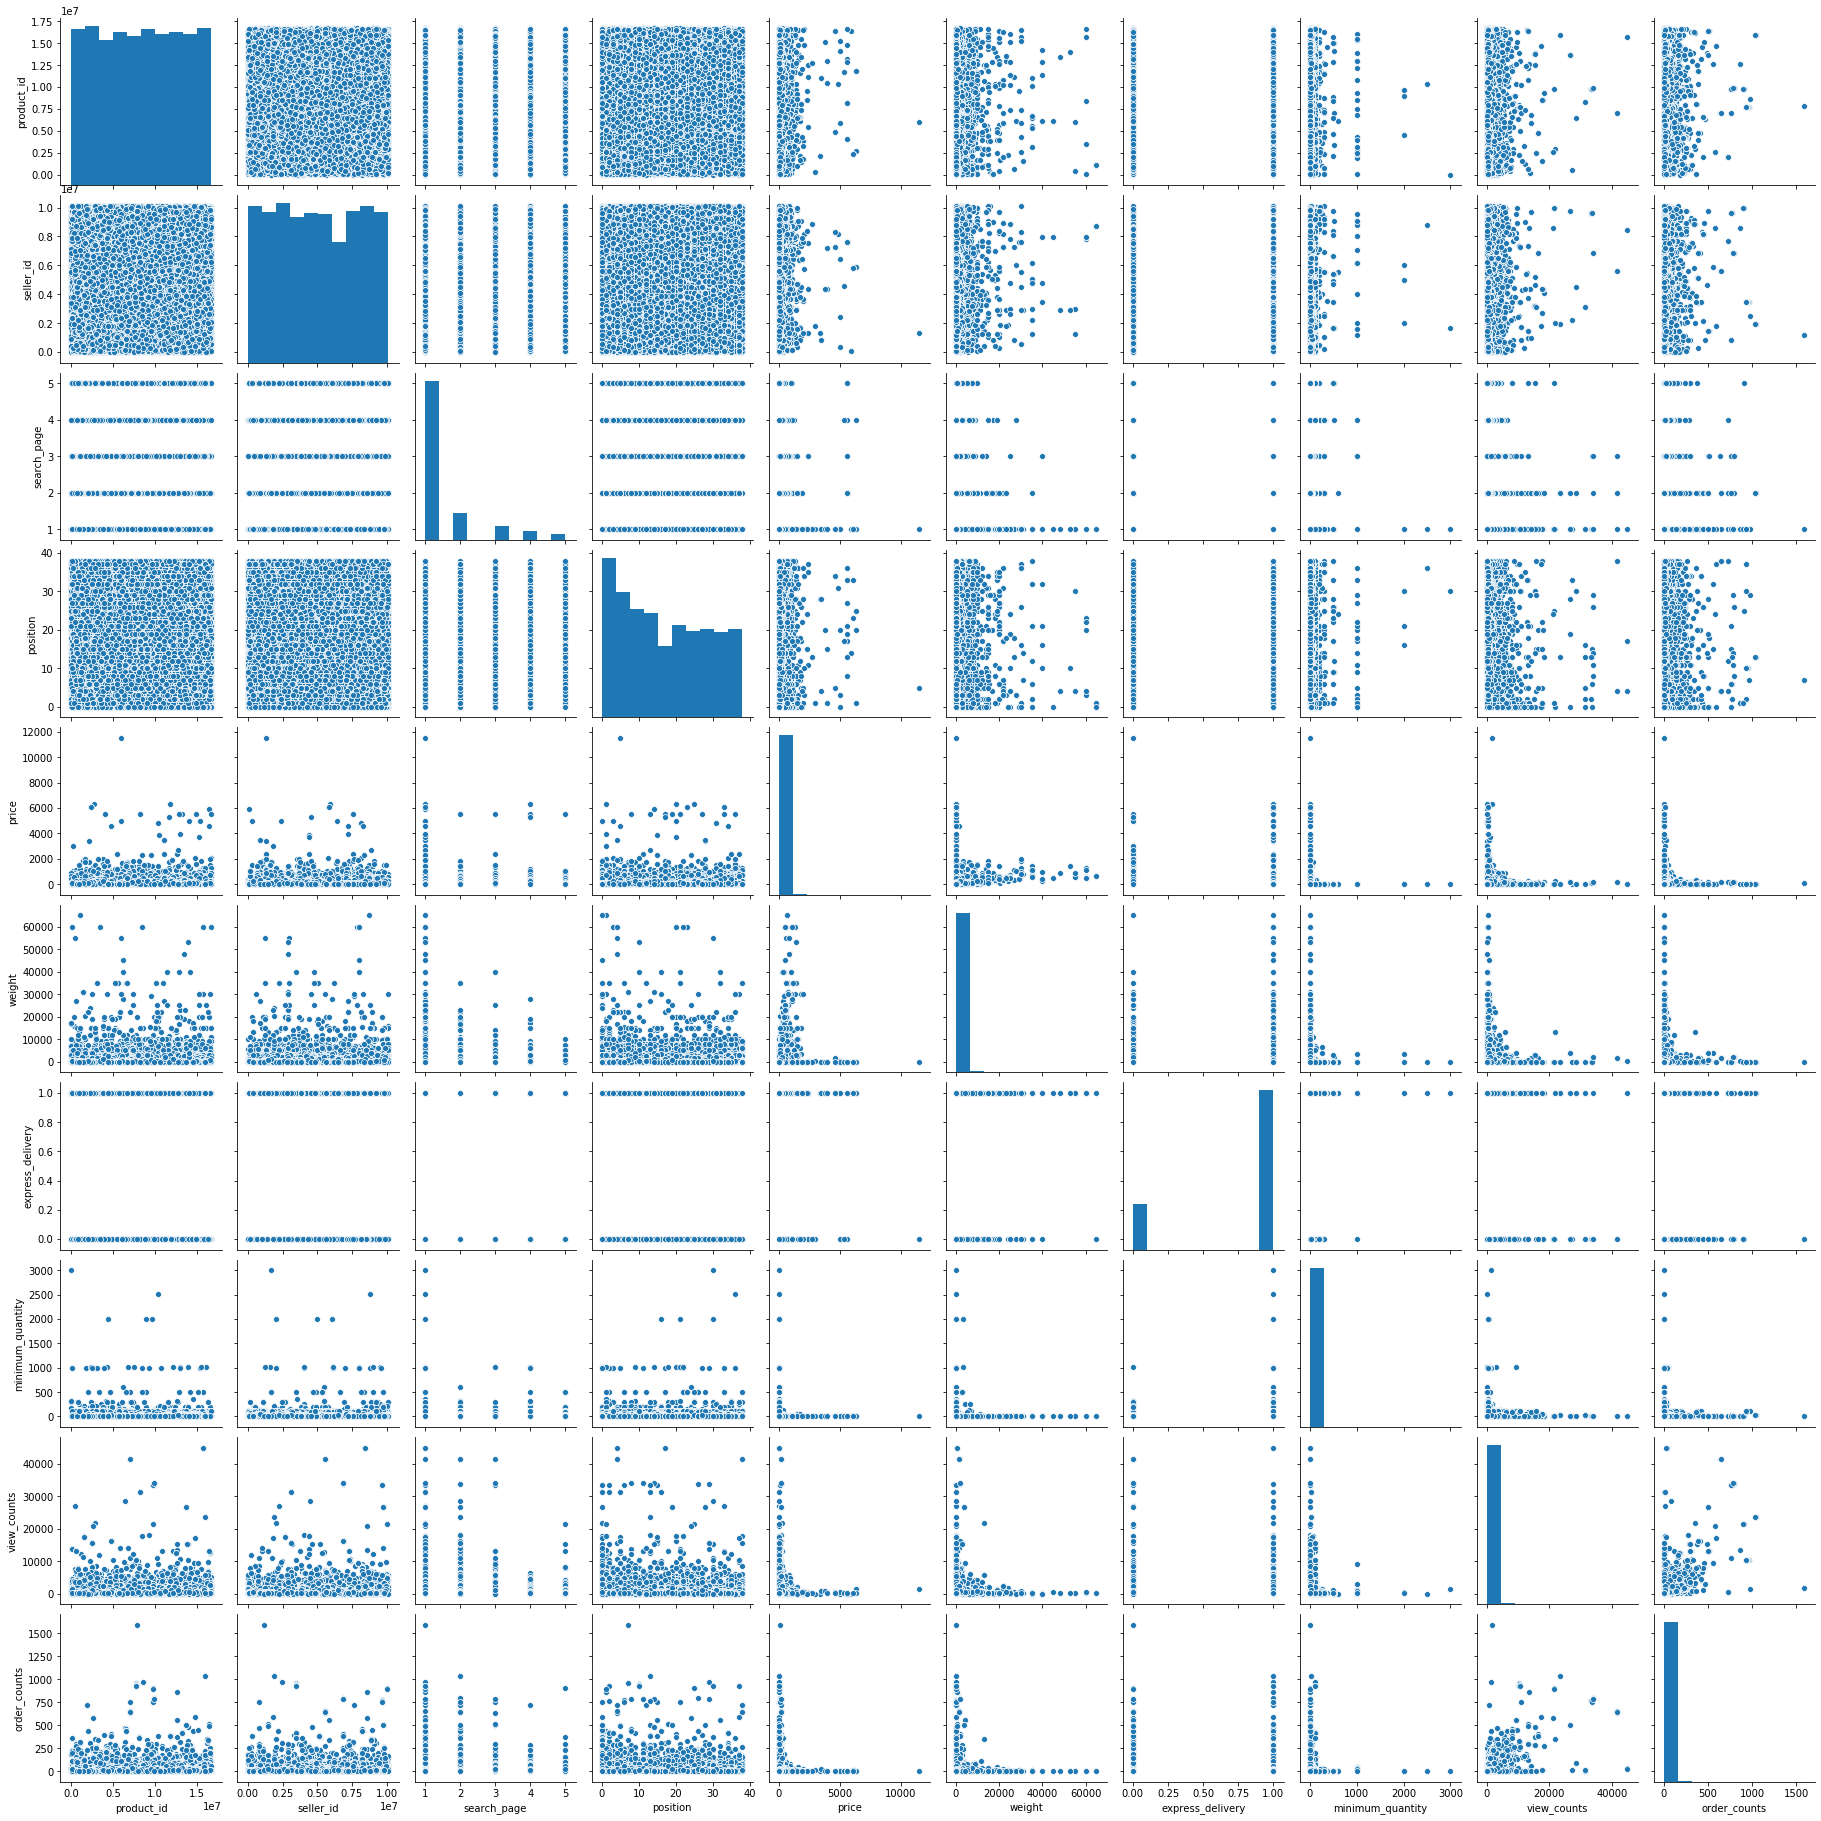

In [54]:
ax = sns.pairplot(dados)

In [55]:
dados['query'].value_counts()

bolsa maternidade                            135
dia dos pais                                 122
porta maternidade                            110
lembrancinha                                 110
batizado                                     110
                                            ... 
girafa amigurumi                               1
caminho de mesa em croche                      1
porta temperos de parede                       1
topo de bolo de repente 30                     1
lembrancinha festa infantil os vingadores      1
Name: query, Length: 6199, dtype: int64

In [56]:
dados['concatenated_tags'].value_counts()

dia pais                                                          708
lembrancinhas                                                     172
batizado                                                           99
tapetes                                                            78
decoracao                                                          67
                                                                 ... 
padrinhos caneca 15 anos                                            1
cha bebe alcool gel                                                 1
fotolivros panoramicos aniversario                                  1
maternidade lembrancinhas evento geral suspiros.. lembrancinha      1
lembrancinhas maju maternidade marina lembrancinha difusor          1
Name: concatenated_tags, Length: 21020, dtype: int64

## Feature Engineering

In [57]:
dados['log_price'] = np.log(dados['price'])
dados['log_weight'] = np.log(dados['weight'])

In [58]:
dados.loc[dados['weight'] <= 30.0, 'ate_30g'] = 1
dados.loc[(dados['weight'] > 30.0)&(dados['weight'] <= 100.0), '30_a_100g'] = 1
dados.loc[(dados['weight'] > 100.0)&(dados['weight'] <= 225.0), '100_a_225g'] = 1
dados.loc[dados['weight'] > 225.0, 'acima_225g'] = 1

In [59]:
dados.loc[dados['price'] <= 25.0, 'ate_25reais'] = 1
dados.loc[(dados['price'] > 25.0)&(dados['price'] <= 60.0), '25_a_60reais'] = 1
dados.loc[(dados['price'] > 60.0)&(dados['price'] <= 120.0), '60_a_120reais'] = 1
dados.loc[dados['price'] > 120.0, 'acima_120reais'] = 1

In [60]:
dados.fillna(0,inplace=True)

In [61]:
dados.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category,log_price,log_weight,ate_30g,30_a_100g,100_a_225g,acima_225g,ate_25reais,25_a_60reais,60_a_120reais,acima_120reais
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,0.0,Decoração,5.146855,7.090077,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,0.0,Papel e Cia,4.352469,2.079442,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,0.0,Outros,4.302984,7.904335,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,0.0,Decoração,5.256505,6.228511,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,4336889,3436479,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,49.970000,208.0,1,1,1093,0.0,Lembrancinhas,3.911423,5.337538,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Sistema de Classificação

O sistema de classificação desse problema é do tipo Multi classe, no qual não há apenas verdadeiro ou falso (binário), mas sim varias classes (Bebê Bijuteria e Jóias, Decoração, Lembrancinhas, Papel e Cia e Outros), totalizando 6 categorias. Primeiro atribuimos a variável X todas as features consideradas preditoras (caracteristicas usadas para descrever o produto) e a variável y que é a classe que queremos prever.

In [62]:
X = dados.drop(['product_id','seller_id','query','title','concatenated_tags','creation_date','category'],axis=1)
y = dados['category'].map({'Bebê':1, 'Bijuterias e Jóias':2, 'Decoração':3, 'Lembrancinhas':4,
                           'Papel e Cia':5, 'Outros':6})

Usamos a função train_test_split para selecionar as amostras de treino (80% do conjunto de dados selecionados de forma aleatória) e as amostras de teste (20% do conjunto de dados).

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [64]:
y_train.value_counts()

4    12448
3     6443
1     4914
5     1938
6      831
2      665
Name: category, dtype: int64

In [65]:
y_test.value_counts()

4    3085
3    1627
1    1239
5     481
6     205
2     173
Name: category, dtype: int64

DADOS DESBALANCEADOS

In [66]:
rf = RandomForestClassifier(n_estimators = 1000,random_state = 42)

rf.fit(X_train,y_train)

y_predict_rf = rf.predict(X_test)

print('Random Forest Test Score : ',rf.score(X_test,y_test))

Random Forest Test Score :  0.6715124816446403


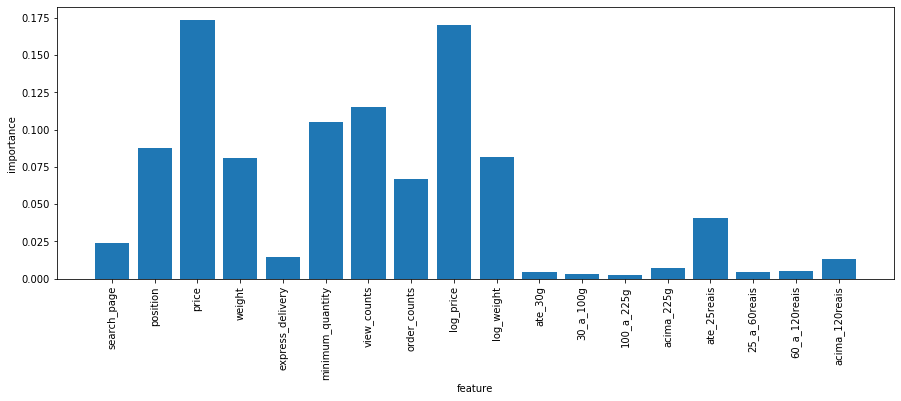

In [67]:
fig, axis = plt.subplots(figsize=(15, 5))
plot = axis.bar(X_train.columns, rf.feature_importances_)
plot = axis.set_xticklabels(X_train.columns.values, rotation='vertical')
plot = axis.set_xlabel('feature')
plot = axis.set_ylabel('importance')
plt.show()

In [68]:
lgbm = LGBMClassifier(n_estimators = 1000,learning_rate = 0.1, random_state = 42)

lgbm.fit(X_train,y_train)

y_predict_lgbm = lgbm.predict(X_test)

print('LGBM Score : ',lgbm.score(X_test,y_test))

LGBM Score :  0.6588839941262848


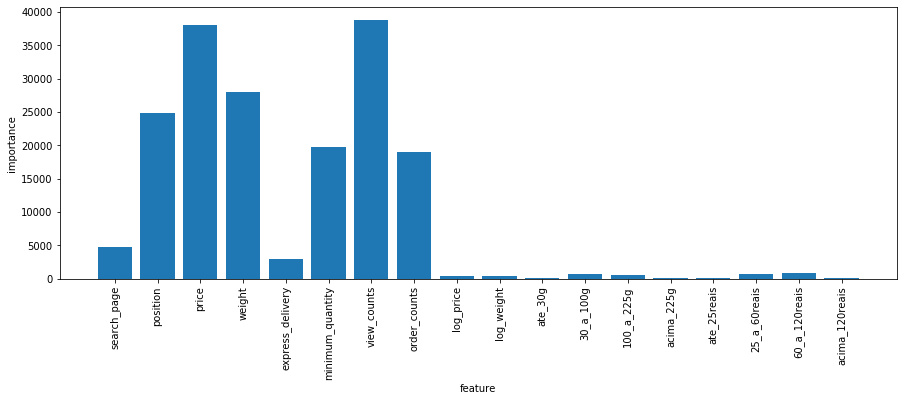

In [69]:
fig, axis = plt.subplots(figsize=(15, 5))
plot = axis.bar(X_train.columns, lgbm.feature_importances_)
plot = axis.set_xticklabels(X_train.columns.values, rotation='vertical')
plot = axis.set_xlabel('feature')
plot = axis.set_ylabel('importance')
plt.show()

## Teste colocando as variáveis na mesma escala

A função MinMaxScaler coloca todas as variáveis numa mesma escala relativa, ou seja, apenas a matriz de intervalo dos valores muda, a forma da distribuição continua a mesma. É o equivalente a ideia de colocar um mapa em escala, o tamanho é diferente, mas as proporções são as mesmas. No caso dessa função, o novo intervalo de valores será entre 0 e 1.

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scale = scaler.fit_transform(X_train)
 
X_test_scale = scaler.fit_transform(X_test)

In [71]:
rf = RandomForestClassifier(n_estimators = 1000,random_state = 42)

rf.fit(X_train_scale,y_train)

print('Random Forest Score : ',rf.score(X_test_scale,y_test))

Random Forest Score :  0.6372980910425844


In [72]:
lgbm = LGBMClassifier(n_estimators = 1000,learning_rate = 0.1, random_state = 42)

lgbm.fit(X_train_scale,y_train)

print('LGBM Score : ',lgbm.score(X_test_scale,y_test))

LGBM Score :  0.5966226138032306


## Teste Normalizando as variáveis

A função StandardScaler padroniza os valores, mudando a forma da distribuição das variáveis.

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
 
X_test_norm = scaler.fit_transform(X_test)

In [74]:
rf = RandomForestClassifier(n_estimators = 100,random_state = 42)

rf.fit(X_train_norm,y_train)

print('Random Forest Score : ',rf.score(X_test_norm,y_test))

Random Forest Score :  0.6490455212922174


In [75]:
lgbm = LGBMClassifier(n_estimators = 1000,learning_rate = 0.01, random_state = 42)

lgbm.fit(X_train_norm,y_train)

print('LGBM Score : ',lgbm.score(X_test_norm,y_test))

LGBM Score :  0.6267254038179149


# Avaliação do Sistema de Classificação

### Matriz de Confusão

Matriz de confusão é uma tabela com os erros de classificação do modelo. A tabela nos mostra a contagem de registros que eram da classe X (linha) e foram classificadas na classe Y (coluna). Em um problema de classificação binária, podemos ter 4 tipos de valores:

 - Verdadeiro Positivo (True Positive): É quando a classe prevista é igual a classe real. São os valores              representados pela diagonal principal da matriz. Exemplo, temos um sistema com falha e o modelo o classificou      como sistema com falha.


 - Falso Positivo (False Positive): É quando a classe prevista é diferente da classe real. Exemplo, temos um          sistema saudável, e o modelo o classificou como um sistema com falha.


 - Falso Verdadeiro (True Negative): É quando a classe prevista é igual a classe real, mas não é a classe que        queremos prever. Exemplo, temos um sistema saudável e o modelo o classificou como sistema saudável (lembrando      que nesse exemplo estamos buscando sistemas com falhas).


 - Falso Negativo (False Negative): Seguindo nesse exemplo, é quando o modelo classifica um sistema com falha como    um sistema saudável.


Isso faz muito sentido para um sistema binário. Para um sistema multiclasses, temos que olhar cada classe separadamente. Temos algumas métricas que são decorrentes da matriz de confusão, como os valores de precisão e recall. Esses valores são calculados da seguinte forma:


 - Precision = True Positive/(True Positive + False Positive)
 
 - Recall = True Positive/(True Positive + False Negative)
 
 - F-score = (2 * precision * recall)/(precision + recall)

Abaixo temos a matriz de Confusão do nosso modelo:

In [76]:
print('Matriz de Confusão Random Forest')
cm_rf =confusion_matrix(y_test, y_predict_rf)  
index = ['Bebê','Biju/Jóias','Decoração','Lembrancinhas','Papel/Cia','Outros']  
columns = ['Bebê','Biju/Jóias','Decoração','Lembrancinhas','Papel/Cia','Outros']  
cm_df_rf = pd.DataFrame(cm_rf,columns,index)                      
print(cm_df_rf)

Matriz de Confusão Random Forest
               Bebê  Biju/Jóias  Decoração  Lembrancinhas  Papel/Cia  Outros
Bebê            593          10        363            252         13       8
Biju/Jóias       51          51         39             26          5       1
Decoração       282          17       1116            187         17       8
Lembrancinhas   111           7        187           2754         22       4
Papel/Cia        54           2        118            259         41       7
Outros           25           2         72             84          4      18


Nessa matriz, temos que os resultados foram:

 - Classe Bebê: 593 registros foram classificadas corretamente, de um total de 1239 registros dessa classe.          Foram classificados como Bijuteria e Jóias 10 registros, 363 registros na classe Decoração, 252 na classe          Lembrancinhas, 13 na classe Papel/Cia e 8 na classe Outros. Essa é a terceira classe em relação à quantidade de    registros disponíveis.
 
 
 - Classe Bijuteria/Jóias: 51 registros foram classificados corretamente, de um total de 173 registros dessa          classe. Foram classificados como Bebê 51 registros, 39 registros na classe Decoração, 26 na classe                Lembrancinhas, 5 na classe Papel/Cia e 1 em Outros. Essa classe é a que menos possui quantidade de registros.
 
 
 - Classe Decaração: 1116 registros foram classificados corretamente, de um total de 1627 registros dessa            classe. Foram classificados como Bebê 282 registros, 17 na classe Bijuteria/Jóias, 187 na classe Lembrancinhas,    17 na classe Papel/Cia e 8 na classe Outros. Essa classe fica em segundo lugar em relação à quantidade de          registros disponíveis.
 
 
 - Classe Lembrancinhas: 2754 registros foram classificados corretamente, de um total de 3085 registros. Foram        classificados como Bebê 111 registros, 7 na classe Bijuteria/Jóias, 187 na classe Decoração, 22 na classe          Papel/Cia e 4 na classe Outros. Essa é a classe que possui o maior número de registros disponíveis.
 

 - Classe Papel e Cia: 41 registros foram classificados corretamente, de um total de 481 registros. Foram            classificados como Bebê 54 registros, 2 na classe Bijuteria/Jóias, 118 na classe Decoração, 259 na classe          Lembrancinhas e 7 na classe Outros. 


 - Classe Outros: 18 registros foram classificados corretamente, de um total de 205 registros. Foram                  classificados como Bebê 25 registros, 2 na classe Bijuteria/Jóias, 72 na classe Decoração, 89 na classe            Lembrancinhas e 4 na classe Papel e Cia.
 
 
Temos um conjunto de dados desbalanceado. O número de registros disponíveis para cada classe deveria ser igual. Temos um número muito grande de amostras para a classe Lembrancinhas, e um numero muito pequeno para a classe Bijuteria/Jóias.

Abaixo, seguimos a análise mostrando os valores de precisão, recall e f-score para cada classe.

In [77]:
print(classification_report(y_test, y_predict_rf, digits=3))

              precision    recall  f1-score   support

           1      0.531     0.479     0.504      1239
           2      0.573     0.295     0.389       173
           3      0.589     0.686     0.634      1627
           4      0.773     0.893     0.829      3085
           5      0.402     0.085     0.141       481
           6      0.391     0.088     0.143       205

    accuracy                          0.672      6810
   macro avg      0.543     0.421     0.440      6810
weighted avg      0.642     0.672     0.643      6810



A função classification_report nos mostra os valores de precisão, recall e f-score já calculados para cada classe. Os resultados são:

 - Classe Bebê: 
 
   - precision = (593)/(593 + 523) = 0.5314
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe Bebê, mas na       verdade são de outras classes (olhar os valores da coluna Bebê).
   
   - recall = (593)/(593 + 646) = 0.4786
   
     *Aqui os produtos da categoria Bebê que foram classificados como pertencentes a qualquer outra classe são           falsos negativos (olhar para a linha Bebê).
     
   - f-score = (2 * 0.5314 * 0.4786)/(0.5314 + 0.4786) = 0.5036
 
 
 - Classe Bijuteria/Jóias: 
  
   - precision = (51)/(51 + 38) = 0.573
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe                     Bijuteria/Jóias, mas na verdade são de outras classes (olhar os valores da coluna Bijuteria/Jóias).
   
   - recall = (51)/(51 + 122) = 0.2947
   
     *Aqui os produtos da categoria Bijuteria/Jóias que foram classificados como pertencentes a qualquer outra           classe são falsos negativos (olhar para a linha Bijuteria/Jóias).
     
   - f-score = (2 * 0.573 * 0.2947)/(0.573 + 0.2947) = 0.3893
 
 
 - Classe Decaração: 
 
   - precision = (1116)/(1116 + 779) = 0.5889
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe Decaração,         mas na verdade são de outras classes (olhar os valores da coluna Decaração).
   
   - recall = (1116)/(1116 + 511) = 0.6859
   
     *Aqui os produtos da categoria Decaração que foram classificados como pertencentes a qualquer outra classe         são falsos negativos (olhar para a linha Decaração).
     
   - f-score = (2 * 0.5889 * 0.6859)/(0.5889 + 0.6859) = 0.6337
 
 
 - Classe Lembrancinhas: 
 
   - precision = (2754)/(2754 + 808) = 0.7731
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe                     Lembrancinhas, mas na verdade são de outras classes (olhar os valores da coluna Lembrancinhas).
   
   - recall = (2754)/(2754 + 331) = 0.8927
   
     *Aqui os produtos da categoria Lembrancinhas que foram classificados como pertencentes a qualquer outra             classe são falsos negativos (olhar para a linha Lembrancinhas).
     
   - f-score = (2 * 0.7731 * 0.8927)/(0.7731 + 0.8927) = 0.8286
 
 
 - Classe Papel e Cia: 
 
   - precision = (41)/(41 + 61) = 0.4019
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe                     Papel e Cia, mas na verdade são de outras classes (olhar os valores da coluna Papel e Cia).
   
   - recall = (41)/(41 + 440) = 0.0852
   
     *Aqui os produtos da categoria Papel e Cia que foram classificados como pertencentes a qualquer outra             classe são falsos negativos (olhar para a linha Papel e Cia).
     
   - f-score = (2 * 0.4019 * 0.0852)/(0.4019 + 0.0852) = 0.1405
 
 
 - Classe Outros: 
 
   - precision = (18)/(18 + 28) = 0.3913
   
     *Aqui o falso positivo são todos os produtos que foram classificados como pertencentes a classe                     Outros, mas na verdade são de outras classes (olhar os valores da coluna Outros).
   
   - recall = (18)/(18 + 187) = 0.087
   
     *Aqui os produtos da categoria Outros que foram classificados como pertencentes a qualquer outra                   classe são falsos negativos (olhar para a linha Outros).
     
   - f-score = (2 * 0.3913 * 0.087)/(0.3913 + 0.087) = 0.1423




In [78]:
print('Matriz de Confusão LGBM ')
cm_lgbm =confusion_matrix(y_test, y_predict_lgbm)  
index = ['Bebê','Biju/Jóias','Decoração','Lembrancinhas','Papel/Cia','Outros']  
columns = ['Bebê','Biju/Jóias','Decoração','Lembrancinhas','Papel/Cia','Outros']  
cm_df_lgbm = pd.DataFrame(cm_lgbm,columns,index)                      
print(cm_df_lgbm)

Matriz de Confusão LGBM 
               Bebê  Biju/Jóias  Decoração  Lembrancinhas  Papel/Cia  Outros
Bebê            563          12        393            258          9       4
Biju/Jóias       52          44         48             20          6       3
Decoração       291          10       1097            191         25      13
Lembrancinhas   124           6        200           2713         34       8
Papel/Cia        51           1        118            253         53       5
Outros           32           3         67             85          1      17


In [79]:
print(classification_report(y_test, y_predict_lgbm, digits=3))

              precision    recall  f1-score   support

           1      0.506     0.454     0.479      1239
           2      0.579     0.254     0.353       173
           3      0.570     0.674     0.618      1627
           4      0.771     0.879     0.821      3085
           5      0.414     0.110     0.174       481
           6      0.340     0.083     0.133       205

    accuracy                          0.659      6810
   macro avg      0.530     0.409     0.430      6810
weighted avg      0.632     0.659     0.632      6810

